In [2]:
import pennylane as qml
import pennylane.templates as qmlt
import torch
import os
import random
import numpy as np

In [3]:
seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

In [ ]:
# type: ignore
r"""
Contains the AmplitudeEmbedding template.
"""
# pylint: disable-msg=too-many-branches,too-many-arguments,protected-access
import numpy as np

import pennylane as qml
from pennylane.ops import StatePrep
from pennylane.wires import Wires

# tolerance for normalization
TOLERANCE = 1e-10


class AmplitudeEmbedding(StatePrep):
    r"""Encodes :math:`2^n` features into the amplitude vector of :math:`n` qubits.

    By setting ``pad_with`` to a real or complex number, ``features`` is automatically padded to dimension
    :math:`2^n` where :math:`n` is the number of qubits used in the embedding.

    To represent a valid quantum state vector, the L2-norm of ``features`` must be one.
    The argument ``normalize`` can be set to ``True`` to automatically normalize the features.

    If both automatic padding and normalization are used, padding is executed *before* normalizing.

    .. note::

        On some devices, ``AmplitudeEmbedding`` must be the first operation of a quantum circuit.

    .. warning::

        At the moment, the ``features`` argument is **not differentiable** when using the template, and
        gradients with respect to the features cannot be computed by PennyLane.

    Args:
        features (tensor_like): input tensor of dimension ``(2^len(wires),)``, or less if `pad_with` is specified
        wires (Any or Iterable[Any]): wires that the template acts on
        pad_with (float or complex): if not None, the input is padded with this constant to size :math:`2^n`
        normalize (bool): whether to automatically normalize the features
        id (str): custom label given to an operator instance,
            can be useful for some applications where the instance has to be identified.

    Example:

        Amplitude embedding encodes a normalized :math:`2^n`-dimensional feature vector into the state
        of :math:`n` qubits:

        .. code-block:: python

            import pennylane as qml

            dev = qml.device('default.qubit', wires=2)

            @qml.qnode(dev)
            def circuit(f=None):
                qml.AmplitudeEmbedding(features=f, wires=range(2))
                return qml.expval(qml.PauliZ(0)), qml.state()

            res, state = circuit(f=[1/2, 1/2, 1/2, 1/2])

        The final state of the device is - up to a global phase - equivalent to the input passed to the circuit:

        >>> state
        tensor([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j], requires_grad=True)

        **Differentiating with respect to the features**

        Due to non-trivial classical processing to construct the state preparation circuit,
        the features argument is in general **not differentiable**.

        **Normalization**

        The template will raise an error if the feature input is not normalized.
        One can set ``normalize=True`` to automatically normalize it:

        .. code-block:: python

            @qml.qnode(dev)
            def circuit(f=None):
                qml.AmplitudeEmbedding(features=f, wires=range(2), normalize=True)
                return qml.expval(qml.PauliZ(0)), qml.state()

            res, state = circuit(f=[15, 15, 15, 15])

        >>> state
        tensor([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j], requires_grad=True)

        **Padding**

        If the dimension of the feature vector is smaller than the number of amplitudes,
        one can automatically pad it with a constant for the missing dimensions using the ``pad_with`` option:

        .. code-block:: python

            from math import sqrt

            @qml.qnode(dev)
            def circuit(f=None):
                qml.AmplitudeEmbedding(features=f, wires=range(2), pad_with=0.)
                return qml.expval(qml.PauliZ(0)), qml.state()

            res, state = circuit(f=[1/sqrt(2), 1/sqrt(2)])

        >>> state
        tensor([0.70710678+0.j, 0.70710678+0.j, 0.        +0.j, 0.        +0.j], requires_grad=True)

    """

    def __init__(self, features, wires, pad_with=None, normalize=False, id=None):
        # pylint:disable=bad-super-call
        wires = Wires(wires)
        self.pad_with = pad_with
        self.normalize = normalize
        features = self._preprocess(features, wires, pad_with, normalize)
        super(StatePrep, self).__init__(features, wires=wires, id=id)

    @staticmethod
    def compute_decomposition(
        features, wires
    ):  # pylint: disable=arguments-differ,arguments-renamed
        r"""Representation of the operator as a product of other operators.

        .. math:: O = O_1 O_2 \dots O_n.



        .. seealso:: :meth:`~.AmplitudeEmbedding.decomposition`.

        Args:
            features (tensor_like): input tensor of dimension ``(2^len(wires),)``
            wires (Any or Iterable[Any]): wires that the operator acts on

        Returns:
            list[.Operator]: decomposition of the operator

        **Example**

        >>> features = torch.tensor([1., 0., 0., 0.])
        >>> qml.AmplitudeEmbedding.compute_decomposition(features, wires=["a", "b"])
        [StatePrep(tensor([1., 0., 0., 0.]), wires=['a', 'b'])]
        """
        return [StatePrep(features, wires=wires)]

    @staticmethod
    def _preprocess(features, wires, pad_with, normalize):
        """Validate and pre-process inputs as follows:

        * If features is batched, the processing that follows is applied to each feature set in the batch.
        * Check that the features tensor is one-dimensional.
        * If pad_with is None, check that the last dimension of the features tensor
          has length :math:`2^n` where :math:`n` is the number of qubits. Else check that the
          last dimension of the features tensor is not larger than :math:`2^n` and pad features
          with value if necessary.
        * If normalize is false, check that last dimension of features is normalised to one. Else, normalise the
          features tensor.
        """

        # check if features is batched
        batched = qml.math.ndim(features) > 1

        if batched and qml.math.get_interface(features) == "tensorflow":
            raise ValueError(
                "AmplitudeEmbedding does not support batched Tensorflow features."
            )

        features_batch = features if batched else [features]

        new_features_batch = []
        # apply pre-processing to each features tensor in the batch
        for feature_set in features_batch:
            shape = qml.math.shape(feature_set)

            # check shape
            if len(shape) != 1:
                raise ValueError(
                    f"Features must be a one-dimensional tensor; got shape {shape}."
                )

            n_features = shape[0]
            dim = 2 ** len(wires)
            if pad_with is None and n_features != dim:
                raise ValueError(
                    f"Features must be of length {dim}; got length {n_features}. "
                    f"Use the 'pad_with' argument for automated padding."
                )

            if pad_with is not None:
                if n_features > dim:
                    raise ValueError(
                        f"Features must be of length {dim} or "
                        f"smaller to be padded; got length {n_features}."
                    )

                # pad
                if n_features < dim:
                    padding = [pad_with] * (dim - n_features)
                    padding = qml.math.convert_like(padding, feature_set)
                    feature_set = qml.math.hstack([feature_set, padding])

            # normalize
            norm = qml.math.sum(qml.math.abs(feature_set) ** 2)

            if qml.math.is_abstract(norm):
                if normalize or pad_with:
                    feature_set = feature_set / qml.math.sqrt(norm)

            elif not qml.math.allclose(norm, 1.0, atol=TOLERANCE):
                if normalize or pad_with:
                    feature_set = feature_set / qml.math.sqrt(norm)
                else:
                    raise ValueError(
                        f"Features must be a vector of norm 1.0; got norm {norm}. "
                        "Use 'normalize=True' to automatically normalize."
                    )

            new_features_batch.append(feature_set)

        return qml.math.cast(
            qml.math.stack(new_features_batch) if batched else new_features_batch[0],
            np.complex128,
        )

In [26]:
@qml.qnode(qml.device("default.qubit", wires=n_qubits), interface="torch")
@qml.transforms.merge_amplitude_embedding
def circuit(inputs, weights):
    # qmlt.AngleEmbedding(inputs, wires=range(n_qubits))
    qmlt.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    qmlt.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    qmlt.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [130]:
# circuit = qml.transforms.broadcast_expand(circuit)

In [27]:
inputs = torch.randn(2, 3, 2**n_qubits).reshape(-1, 2**n_qubits)
# inputs = torch.randn(2, 3, n_qubits)
weights = torch.randn(n_qubits, n_qubits)
print(inputs)
print(inputs.shape)
print(weights)

tensor([[-0.2073,  0.4188,  1.7955, -0.6994, -0.4368,  0.3443, -0.5315, -1.7879,
          0.5760, -0.3711, -0.0215, -0.3246,  0.7542, -1.7302, -0.6405, -0.0244],
        [ 1.7320,  0.3924, -0.3705,  0.8811,  0.5374, -0.4842, -1.1633,  0.3276,
         -1.6854, -1.0582,  1.4544, -0.2976, -0.8741, -1.0332, -0.4152,  1.5586],
        [ 0.5210,  1.0364,  0.2102, -1.1503, -0.2583,  0.2814, -0.5159,  1.5220,
         -0.4228,  0.5676,  0.4795, -0.9629,  0.1665,  0.1792, -0.6149,  0.8849],
        [-0.8721, -1.3770, -1.8488,  0.3056, -0.4245,  0.6270, -0.6439,  3.0599,
          0.8689,  0.7332,  1.7552, -0.2425,  1.9881, -1.1370, -2.2500, -0.5811],
        [-0.7490, -2.1544, -0.1569,  0.0973,  0.2539,  1.5049,  1.3131, -0.7395,
         -1.8136, -0.2882, -0.4023,  0.7287, -0.4994,  0.7028,  0.3422, -1.3413],
        [ 2.5906, -0.1442, -0.4769, -0.2289,  0.3704,  1.0243,  0.3509, -0.1160,
         -0.5129,  0.8614,  2.6178,  0.8523,  0.3443, -0.2194,  1.6952,  0.7313]])
torch.Size([6, 16])
t

In [29]:
qml.matrix(circuit, wire_order=range(n_qubits))(inputs, weights)

ValueError: Broadcasting with MottonenStatePreparation is not supported. Please use the qml.transforms.broadcast_expand transform to use broadcasting with MottonenStatePreparation.

0: ─╭|Ψ⟩──RX(-0.71)─╭●───────╭X──RX(0.95)──╭●───────╭X──RX(-0.59)─╭●───────╭X──RX(0.13)──╭●───────╭X─┤
1: ─├|Ψ⟩──RX(1.51)──╰X─╭●────│───RX(-1.34)─╰X─╭●────│───RX(-1.67)─╰X─╭●────│───RX(-1.00)─╰X─╭●────│──┤
2: ─├|Ψ⟩──RX(0.91)─────╰X─╭●─│───RX(0.96)─────╰X─╭●─│───RX(-1.34)────╰X─╭●─│───RX(0.93)─────╰X─╭●─│──┤
3: ─╰|Ψ⟩──RX(-1.30)───────╰X─╰●──RX(-1.83)───────╰X─╰●──RX(-0.79)───────╰X─╰●──RX(-1.10)───────╰X─╰●─┤

   <Z>
   <Z>
   <Z>
   <Z>


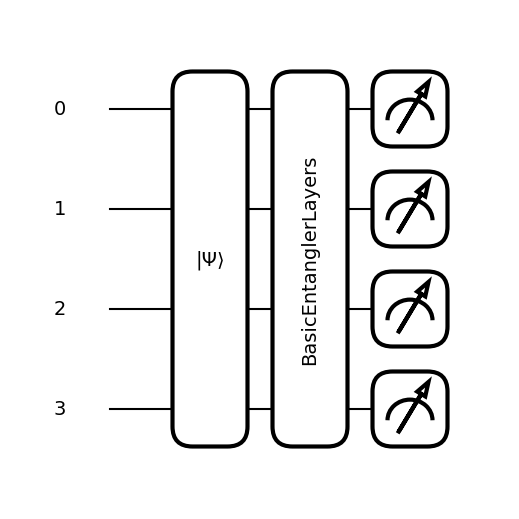

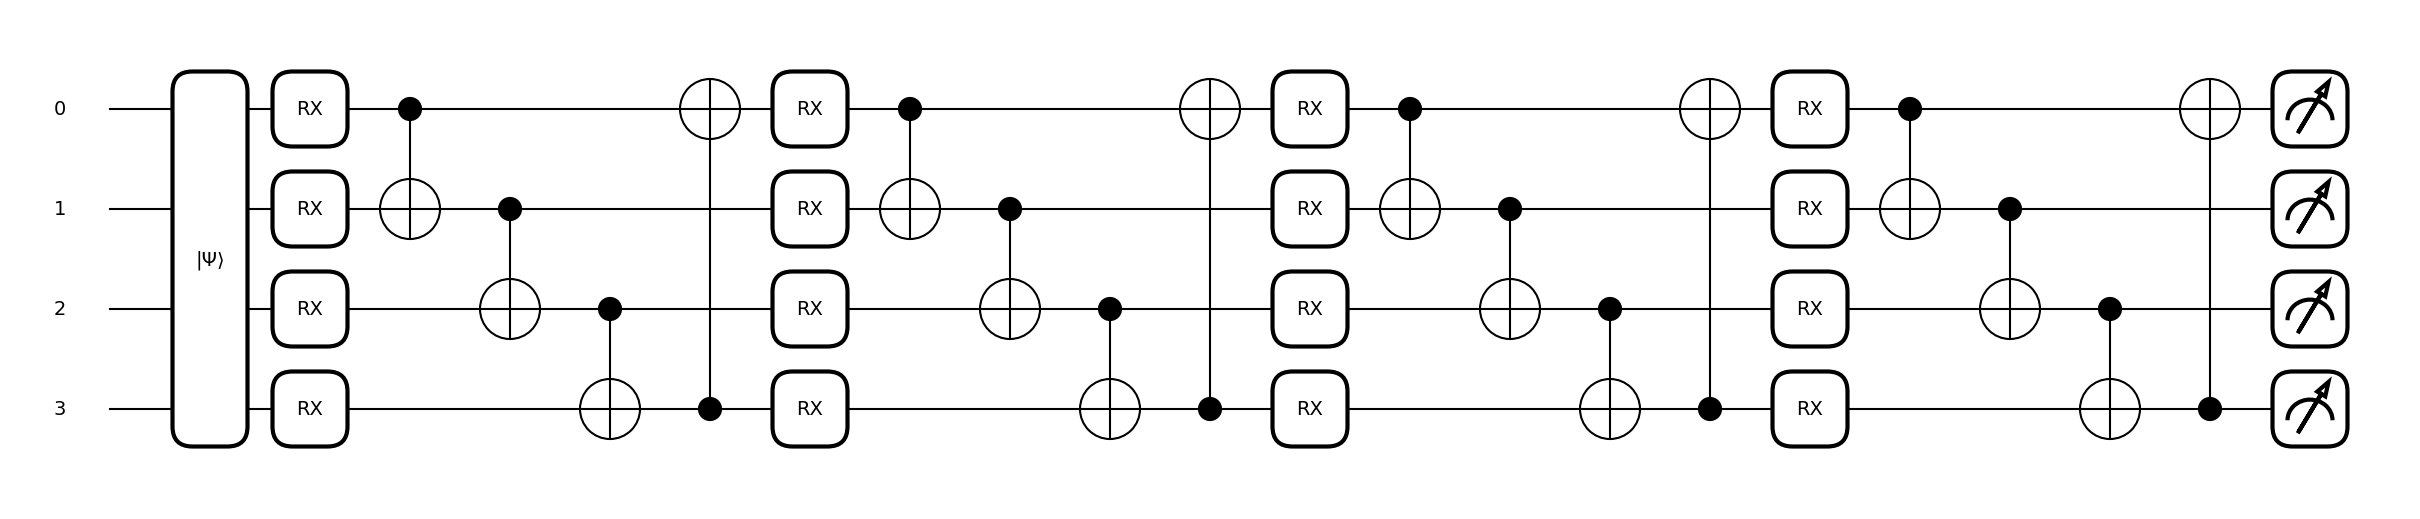

In [28]:
# qml.drawer.use_style("pennylane")
print(qml.draw(circuit, level="device")(inputs, weights))
fig1, ax = qml.draw_mpl(circuit)(inputs, weights)
fig2, ax = qml.draw_mpl(circuit, level="device")(inputs, weights)

In [53]:
np.random.seed(42)


@qml.qnode(qml.device("default.qubit", wires=2))
@qml.transforms.merge_amplitude_embedding
def circuit(m1, m2):
    qml.AmplitudeEmbedding(m1, wires=0, normalize=True)
    qml.AmplitudeEmbedding(m2, wires=1, normalize=True)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(2)]
    # return qml.state()


m1 = np.random.random(size=[3, 2])
m2 = np.random.random(size=[3, 2])
# m1 = np.array([[1, 0], [0, 1]])
# m2 = np.array([[0, 1], [1, 0]])
# m1 = np.array([[2, 0], [0, 2]])
# m2 = np.array([[0, 2], [2, 0]])
print(m1)
print(m2)
print(circuit(m1, m2))
# m1 = np.array([0.18343479, 0.779691])

[[0.18343479 0.779691  ]
 [0.59685016 0.44583275]
 [0.09997492 0.45924889]]
[[0.33370861 0.14286682]
 [0.65088847 0.05641158]
 [0.72199877 0.93855271]]
[tensor([-0.89510572,  0.28371916, -0.90950857], requires_grad=True), tensor([ 0.69020928,  0.98508912, -0.25646009], requires_grad=True)]


In [56]:
n_qubits = 3
m1 = np.random.random(size=[7, 4, 2**n_qubits]).reshape(-1, 2**n_qubits)


@qml.qnode(qml.device("default.qubit", wires=n_qubits))
# @qml.transforms.merge_amplitude_embedding
def circuit(m1, m2):
    qml.AmplitudeEmbedding(m1, wires=range(n_qubits), normalize=True)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(2)]
    # return qml.state()


circuit(m1, m2)

[tensor([ 0.59779414, -0.19558711,  0.49890717,  0.33830187, -0.55755835,
         -0.3373465 ,  0.70762712, -0.78630293,  0.35625232, -0.43307073,
         -0.36690374, -0.14263015,  0.59488372, -0.12319365, -0.23044108,
         -0.05469415,  0.12435575,  0.25508294,  0.12028583,  0.08720948,
         -0.13799203, -0.45427738,  0.0098084 ,  0.24714524,  0.15853436,
         -0.56170603, -0.34469395,  0.17369271], requires_grad=True),
 tensor([ 0.50757132,  0.22158323,  0.09170853, -0.404608  , -0.08181053,
          0.22215566,  0.38054863,  0.04075748, -0.12649909,  0.33622427,
         -0.67409329, -0.18028075,  0.35805075,  0.52084993,  0.35398702,
         -0.75135233,  0.1638582 ,  0.41760854, -0.09446675, -0.11082536,
          0.34016471,  0.27455068, -0.11106492, -0.01447338,  0.31047337,
          0.4069083 ,  0.13373613, -0.43048285], requires_grad=True)]

In [61]:
@qml.qnode(qml.device("default.qubit", wires=n_qubits))
def circuit(m1, m2):
    qml.AngleEmbedding(m1, wires=range(n_qubits), rotation="X")
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    # return qml.state()


m1 = np.random.random(size=[7, 4, n_qubits]).reshape(-1, n_qubits)
circuit(m1, m2)

[tensor([0.96484643, 0.89903272, 0.91663914, 0.99114396, 0.91445424,
         0.9965783 , 0.98644556, 0.88682397, 0.73197625, 0.84239629,
         0.99105517, 0.7701536 , 0.6112433 , 0.72684374, 0.97905176,
         0.97860508, 0.99890056, 0.87846074, 0.95300929, 0.99609454,
         0.8869737 , 0.80247699, 0.81546529, 0.80409523, 0.74757227,
         0.61337361, 0.76635921, 0.66590401], requires_grad=True),
 tensor([0.9357752 , 0.99947789, 0.82376165, 0.99709816, 0.83582494,
         0.63972071, 0.9166198 , 0.55262473, 0.92376837, 0.9979838 ,
         0.99990654, 0.86060174, 0.8336295 , 0.92945976, 0.96855455,
         0.63852154, 0.96412414, 0.88873837, 0.6848593 , 0.70255285,
         0.91287034, 0.69307904, 0.5566382 , 0.84999759, 0.85385652,
         0.95593752, 0.69923336, 0.71866365], requires_grad=True),
 tensor([0.96640287, 0.96112077, 0.96351502, 0.58935846, 0.60647509,
         0.85169349, 0.71259776, 0.92986928, 0.67549227, 0.99932215,
         0.99716185, 0.7317497 , 0.747

0: ──RZ(M0)─┤  <Z>
1: ──RZ(M1)─┤  <Z>

M0 = 
[0.18343479 0.59685016]
M1 = 
[0.779691   0.44583275]


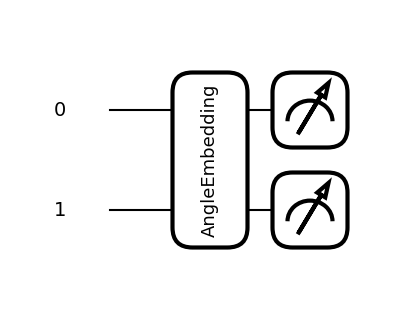

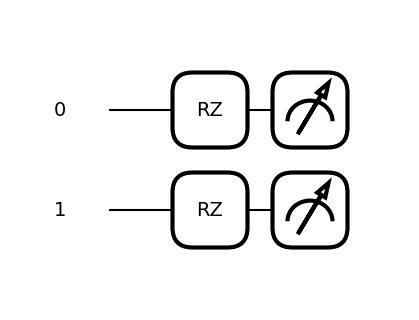

In [27]:
print(qml.draw(circuit, level="device")(m1, m2))
fig1, ax = qml.draw_mpl(circuit)(m1, m2)
fig2, ax = qml.draw_mpl(circuit, level="device")(m1, m2)

0: ──RZ(1.11)───RZ(-1.38)─╭●───────╭X──RZ(0.32)──╭●───────╭X──RZ(-1.56)─╭●───────╭X──RZ(-1.27)─╭●───
1: ──RZ(-1.69)──RZ(-0.87)─╰X─╭●────│───RZ(-0.42)─╰X─╭●────│───RZ(1.00)──╰X─╭●────│───RZ(2.12)──╰X─╭●
2: ──RZ(-0.99)──RZ(-0.22)────╰X─╭●─│───RZ(0.31)─────╰X─╭●─│───RZ(-0.88)────╰X─╭●─│───RZ(-1.23)────╰X
3: ──RZ(0.96)───RZ(1.72)────────╰X─╰●──RZ(-0.77)───────╰X─╰●──RZ(-0.60)───────╰X─╰●──RZ(-0.49)──────

─────╭X─┤  <Z>
─────│──┤  <Z>
──╭●─│──┤  <Z>
──╰X─╰●─┤  <Z>


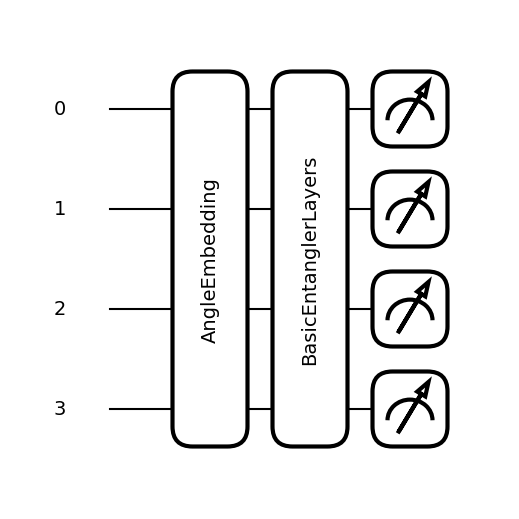

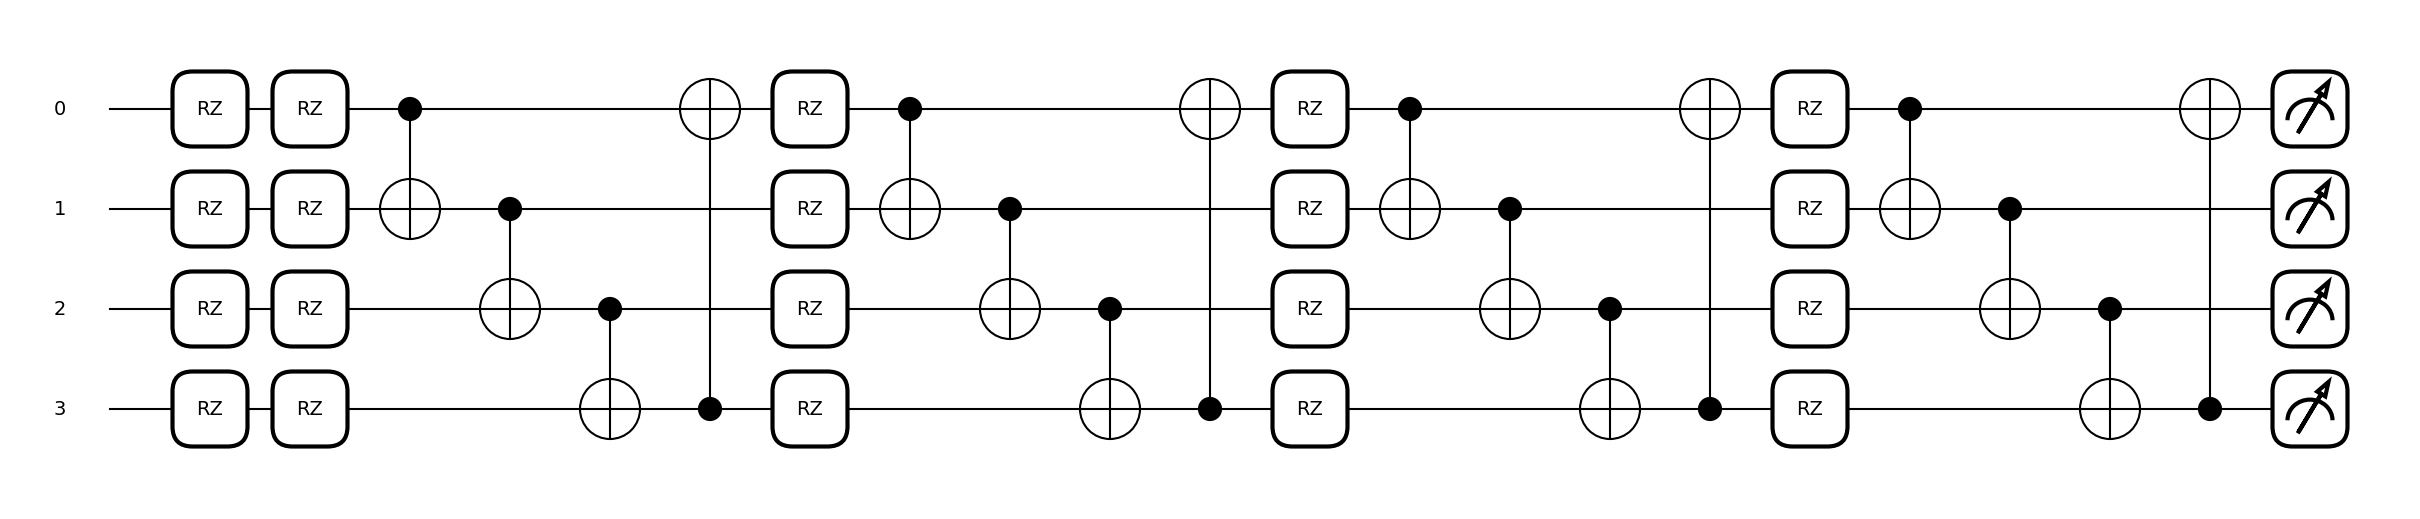

In [8]:
@qml.qnode(qml.device("default.qubit", wires=n_qubits), interface="torch")
def circuit(inputs, weights):
    qmlt.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Z")
    qmlt.BasicEntanglerLayers(weights, wires=range(n_qubits), rotation=qml.RZ)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


inputs = torch.randn(n_qubits)
weights = torch.randn(n_qubits, n_qubits)

print(qml.draw(circuit, expansion_strategy="device")(inputs, weights))
fig1, ax = qml.draw_mpl(circuit)(inputs, weights)
fig2, ax = qml.draw_mpl(circuit, expansion_strategy="device")(inputs, weights)

In [9]:
import pennylane as qml
import numpy as np

# Define the angles you want to encode
angles = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]

# Initialize a quantum device (in this case, a simulator)
dev = qml.device("default.qubit", wires=3)


@qml.qnode(qml.device("default.qubit", wires=n_qubits), interface="torch")
def multiple_angle_embedding_circuit(features):
    # Encode the first 3 features as angles for x rotations
    qml.AngleEmbedding(features[:3], wires=range(3), rotation="X")

    # Encode the next 3 features as angles for z rotations
    qml.AngleEmbedding(features[3:6], wires=range(3), rotation="Z")

    # Encode the last 2 features as angles for y rotations
    qml.AngleEmbedding(features[6:], wires=[0, 1], rotation="Y")

    return qml.state()


# Execute the circuit and get the quantum state
quantum_state = multiple_angle_embedding_circuit(angles)

# Print the quantum state
print(quantum_state)

tensor([ 0.1661-0.4570j,  0.0000+0.0000j, -0.0151-0.1232j,  0.0000+0.0000j,
         0.0921-0.5659j,  0.0000+0.0000j, -0.0446-0.1395j,  0.0000+0.0000j,
         0.1057-0.3809j,  0.0000+0.0000j, -0.0201-0.0989j,  0.0000+0.0000j,
         0.0388-0.4645j,  0.0000+0.0000j, -0.0450-0.1102j,  0.0000+0.0000j],
       dtype=torch.complex128)


0: ──RX(0.10)──RZ(0.70)──RY(1.30)─┤ ╭State
1: ──RX(0.30)──RZ(0.90)──RY(1.50)─┤ ├State
2: ──RX(0.50)──RZ(1.10)───────────┤ ├State
3: ───────────────────────────────┤ ╰State


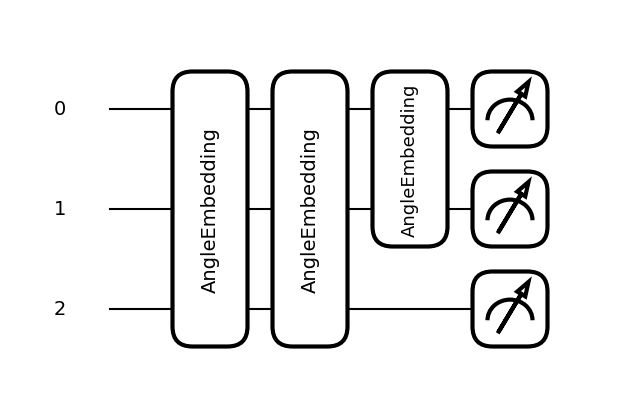

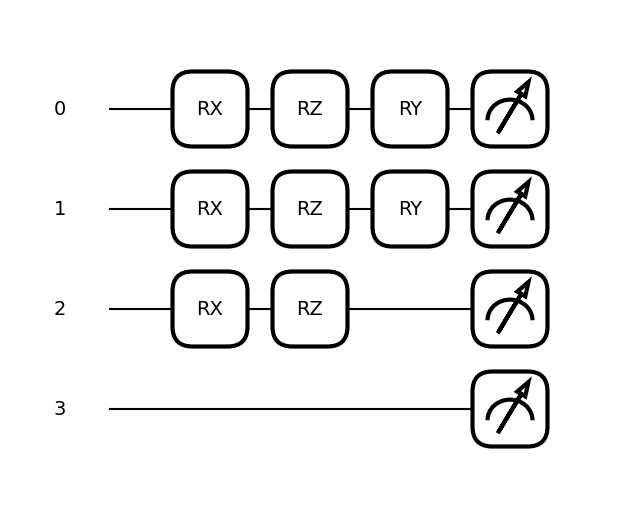

In [10]:
print(qml.draw(multiple_angle_embedding_circuit, expansion_strategy="device")(angles))
fig1, ax = qml.draw_mpl(multiple_angle_embedding_circuit)(angles)
fig2, ax = qml.draw_mpl(multiple_angle_embedding_circuit, expansion_strategy="device")(
    angles
)

Rot(ϕ,θ,ω) = RZ(ω)RY(θ)RZ(ϕ)

0: ──RZ(0.28)───Rot(0.60,0.71,0.02)─╭●───────╭X──Rot(0.61,0.14,0.29)─╭●────╭X────┤  <Z>
1: ──RZ(0.06)───Rot(0.97,0.83,0.21)─╰X─╭●────│───Rot(0.37,0.46,0.79)─│──╭●─│──╭X─┤  <Z>
2: ──RZ(0.52)───Rot(0.18,0.18,0.30)────╰X─╭●─│───Rot(0.20,0.51,0.59)─╰X─│──╰●─│──┤  <Z>
3: ──RZ(-0.24)──Rot(0.52,0.43,0.29)───────╰X─╰●──Rot(0.05,0.61,0.17)────╰X────╰●─┤  <Z>


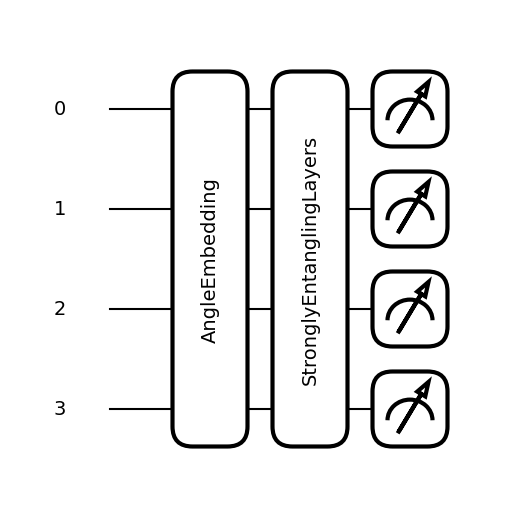

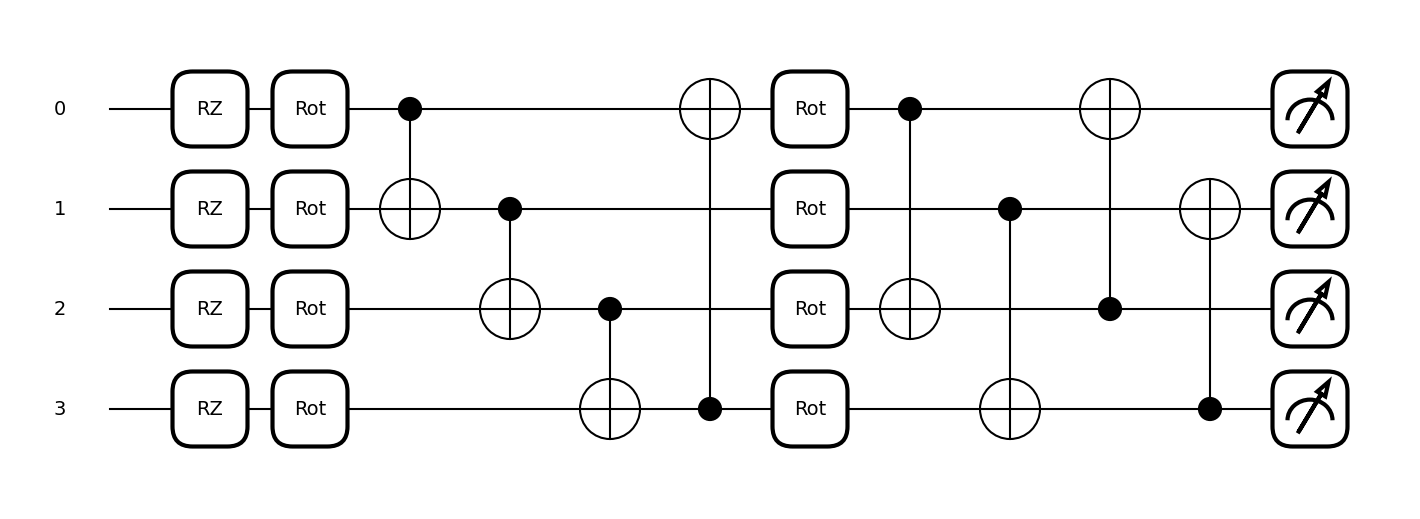

In [11]:
n_qubits = 4
n_qlayers = 2
dev = qml.device("default.qubit", wires=n_qubits)


@qml.qnode(qml.device("default.qubit", wires=n_qubits), interface="torch")
def circuit(inputs, weights):
    qmlt.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Z")
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


inputs = torch.randn(n_qubits)
weights = torch.randn(n_qlayers, n_qubits, 3)

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=4)
weights = np.random.random(size=shape)

print(qml.draw(circuit, expansion_strategy="device")(inputs, weights))
fig1, ax = qml.draw_mpl(circuit)(inputs, weights)
fig2, ax = qml.draw_mpl(circuit, expansion_strategy="device")(inputs, weights)

In [15]:
dev = qml.device("default.qubit", wires=4)


@qml.qnode(dev)
def circuit(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(4))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


shape = qml.StronglyEntanglingLayers.shape(n_layers=n_qlayers, n_wires=n_qubits)
weights = np.random.random(size=shape)

print(weights.shape)

print(qml.draw(circuit, expansion_strategy="device")(weights))

(2, 4, 3)
0: ──Rot(0.52,0.96,0.84)─╭●───────╭X──Rot(0.42,0.39,0.29)─╭●────╭X────┤  <Z>
1: ──Rot(0.75,0.54,0.59)─╰X─╭●────│───Rot(0.01,0.20,0.71)─│──╭●─│──╭X─┤  <Z>
2: ──Rot(0.97,0.61,0.28)────╰X─╭●─│───Rot(0.79,0.61,0.93)─╰X─│──╰●─│──┤  <Z>
3: ──Rot(0.30,0.17,0.02)───────╰X─╰●──Rot(0.65,0.91,0.85)────╰X────╰●─┤  <Z>


In [16]:
print(qml.StronglyEntanglingLayers.shape(n_layers=n_qlayers, n_wires=n_qubits))

(2, 4, 3)


In [18]:
print(qml.BasicEntanglerLayers.shape(n_layers=n_qlayers, n_wires=n_qubits))

(2, 4)


In [13]:
# import torch.nn.functional as F

# # Optionally use the context manager to ensure one of the fused kernels is run
# query = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
# key = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
# value = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
# with torch.backends.cuda.sdp_kernel(enable_math=False):
#     F.scaled_dot_product_attention(query, key, value)